# Sok format
We would follow the formatting convention used for "Sokoban YASC"

## Legend

| Symbol                         | Meaning                              |
| ------------------------------ | ------------------------------------ |
| `#`                            | Wall                                 |
| `p`                            | Pusher                               |
| `P`                            | Pusher on goal square               |
| `b`                            | Box                                  |
| `B`                            | Box on goal square                  |
| `.`                            | Goal square                          |
| ` `                            | Floor                                |
| `-`                            | Floor                                |
| `_`                            | Floor                                |

## Remarks

- The first and last non-empty square in each row must be a wall or a box on a goal.
- An empty interior row must be written with at least one `-` or `_`.

In [1]:
using Printf

mutable struct Sokoban
    width::Int
    height::Int
    player::Tuple{Int, Int}  # Player position (row, col)
    boxes::Vector{Tuple{Int, Int}}  # List of box positions
    goals::Vector{Tuple{Int, Int}}  # List of goal positions
    walls::Vector{Tuple{Int, Int}}  # List of wall positions
end

In [2]:
function extract_levels(file_path::String)::Vector{String}
    file = open(file_path, "r")
    lines = readlines(file)
    close(file)

    levels = String[]
    current_level = []
    recording = false

    for line in lines
        if occursin(r"^\s*#", line)  # Detect level lines starting with "#"
            push!(current_level, line)
            recording = true
        elseif recording
            if isempty(line)  # Empty line indicates the end of a level
                push!(levels, join(current_level, "\n"))
                current_level = []
                recording = false
            end
        end
    end

    if !isempty(current_level)  # Capture last level if no empty line at the end
        push!(levels, join(current_level, "\n"))
    end

    return levels
end

function save_levels(levels::Vector{String}, output_dir::String)
    mkpath(output_dir)  # Ensure output directory exists
    for (i, level) in enumerate(levels)
        file_path = joinpath(output_dir, "level_$i.txt")
        open(file_path, "w") do f
            write(f, level)
        end
    end
end

save_levels (generic function with 1 method)

In [3]:
#extracting levels from file and store in separate txt

file_path = "Xsokoban_90.xsb"  # Path to the file containing levels
output_dir = "Xsokoban_90"  # Directory to store extracted levels

levels = extract_levels(file_path)
save_levels(levels, output_dir)

println("Extracted $(length(levels)) levels and saved to $output_dir")

Extracted 90 levels and saved to Xsokoban_90


In [4]:
# Parse the level into a 2D array (grid)
function parse_level_to_grid(level_str::String)
    return [collect(replace(line, '@' => 'p', '$' => 'b', '+' => 'P', '*' => 'b')) for line in split(level_str, "\n") if !isempty(line)]
end

parse_level_to_grid (generic function with 1 method)

In [5]:
# Render the grid
function render_grid_text(grid::Vector{Vector{Char}})
    for row in grid
        println(join(row))
    end
end

render_grid_text (generic function with 1 method)

In [6]:
# Find player position
function find_player_position(grid::Vector{Vector{Char}})
    for (i, row) in enumerate(grid)
        for (j, cell) in enumerate(row)
            if cell == 'p' || cell == 'P'
                return (i, j)  # Return row, column of the player
            end
        end
    end
    error("Player not found in the grid!")
end

find_player_position (generic function with 1 method)

In [7]:
# Move the player on the grid
function move_player!(grid::Vector{Vector{Char}}, direction::String)
    # Get player position
    row, col = find_player_position(grid)
    
    # Determine the new player position based on direction
    new_row, new_col = row, col
    
    if direction == "up" && row > 1
        new_row -= 1
    elseif direction == "down" && row < length(grid)
        new_row += 1
    elseif direction == "left" && col > 1
        new_col -= 1
    elseif direction == "right" && col < maximum(length, grid)  # Check right boundary correctly
        new_col += 1
    else
        println("Invalid move!, out of bound")
        return (row, col)  # Return the original position if out of bounds
    end
    
    # Get the character at the new position
    new_pos = grid[new_row][new_col]
    
    if new_pos == ' ' || new_pos == '-' || new_pos == '_'  # Empty space or floor
        # Move player to the empty space
        if grid[row][col] == 'p'  # Player was on the floor
            grid[new_row][new_col] = 'p'  # Move to new floor position
            grid[row][col] = ' '  # Clear old player position
        elseif grid[row][col] == 'P'  # Player was on goal
            grid[new_row][new_col] = 'p'  # Move to floor after leaving goal
            grid[row][col] = '.'  # Clear old player position
        end
        
        return (new_row, new_col)
    
    elseif new_pos == '.'  # Goal square
        # Move player to the goal square
        if grid[row][col] == 'p'  # Player was on floor
            grid[new_row][new_col] = 'P'  # Move to goal square
            grid[row][col] = ' '  # Clear old player position
        elseif grid[row][col] == 'P'  # Player already on goal
            grid[new_row][new_col] = 'P'  # Player stays on goal
            grid[row][col] = '.'  # Clear old player position
        end
        
        return (new_row, new_col)
    
    elseif new_pos == 'b' || new_pos == 'B'  # Box
        # Try to move the box
        if can_move_box(grid, new_row, new_col, direction)
            # Move the box to the target or empty spot
            if new_pos == 'B'  # Box was on the goal square
                grid[new_row][new_col] = 'P'  # Keep box on goal square
            else
                grid[new_row][new_col] = 'p'  # Box moves to floor
            end
            grid[row][col] = ' '  # Clear old player position
            return (new_row, new_col)
        else
            println("Cannot move box!")
            return (row, col)  # Return player position if move not possible
        end
    else
        println("Invalid move! You are hitting the wall")
        return (row, col)  # Return the original position if invalid move
    end
end

move_player! (generic function with 1 method)

In [8]:
# Function to check if a box can be moved
function can_move_box(grid::Vector{Vector{Char}}, row::Int, col::Int, direction::String)
    # Determine where the box will move based on the direction
    if direction == "up"
        target_row, target_col = row - 1, col
    elseif direction == "down"
        target_row, target_col = row + 1, col
    elseif direction == "left"
        target_row, target_col = row, col - 1
    elseif direction == "right"
        target_row, target_col = row, col + 1
    else
        return false  # Invalid direction
    end
    
    # Check if the target position is valid (empty space or goal)
    if grid[target_row][target_col] == ' ' || grid[target_row][target_col] == '-' || grid[target_row][target_col] == '_'
        grid[target_row][target_col] = 'b'
        return true  # Box can be moved to an empty floor space
    elseif grid[target_row][target_col] == '.'
        grid[target_row][target_col] = 'B'
        return true  # Box can be moved to a goal square
    else
        return false  # Box cannot be moved to walls or other boxes
    end
end

can_move_box (generic function with 1 method)

In [9]:
# Check if the game is won (all boxes are on target positions)
function check_win(grid::Vector{Vector{Char}})
    for row in grid
        for cell in row
            if cell == 'b'  # If there's still a box that isn't on the target, the game is not won
                return false
            end
        end
    end
    return true  # If no boxes are left, the game is won
end

check_win (generic function with 1 method)

In [10]:
# Function to ask user for the mode (text or image)
function choose_mode()
    println("Choose the mode: (1) Text Mode, (2) Image Mode")
    mode = readline()
    if mode == "1"
        return "text"
    elseif mode == "2"
        return "image"
    else
        println("Invalid choice. Defaulting to text mode.")
        return "text"
    end
end

choose_mode (generic function with 1 method)

In [11]:
using Images
using ColorTypes
using Plots

# Define the color map for each character
color_map = Dict(
    '#' => RGB(0.5, 0.5, 0.5),    # Grey (Wall)
    ' ' => RGB(1.0, 1.0, 1.0),    # White (Inside floor)
    'o' => RGB(0.0, 0.0, 0.0),    # Blue (Outside floor)
    '.' => RGB(1.0, 1.0, 0.0),    # Yellow (Goal)
    'b' => RGB(1.0, 0.0, 0.0),    # Red (Box)
    'B' => RGB(1.0, 0.5, 0.0),    # Yellow (Box on Goal)
    'p' => RGB(0.0, 1.0, 0.0),    # Green (Player)
    'P' => RGB(0.0, 1.0, 1.0)     # Green (Player on Goal)
)

Dict{Char, RGB{Float64}} with 8 entries:
  'B' => RGB{Float64}(1.0,0.5,0.0)
  '.' => RGB{Float64}(1.0,1.0,0.0)
  'P' => RGB{Float64}(0.0,1.0,1.0)
  '#' => RGB{Float64}(0.5,0.5,0.5)
  'p' => RGB{Float64}(0.0,1.0,0.0)
  'o' => RGB{Float64}(0.0,0.0,0.0)
  ' ' => RGB{Float64}(1.0,1.0,1.0)
  'b' => RGB{Float64}(1.0,0.0,0.0)

In [25]:
# Function to render the grid as an image with adjustable cell size
function render_grid_images(grid::Vector{Vector{Char}}, cell_size=50)
    rows, cols = length(grid), length(grid[1])

    # Convert the grid into a color matrix
    color_matrix = [color_map[grid[i][j]] for i in 1:rows, j in 1:cols]

    # Create the heatmap
    img = heatmap(
        color_matrix,
        axis=false,
        color=:auto,
        size=(cols * cell_size, rows * cell_size)  # Adjust grid cell size
    )

    # Display the image
    IJulia.display(img)
    #display(img)
end

render_grid_images (generic function with 2 methods)

In [13]:
function mark_outside_floor!(grid::Vector{Vector{Char}})
    # Find the maximum length of any row
    max_cols = maximum(map(length, grid))
    for row in grid
        # Left to right pass
        for i in eachindex(row)
            if row[i] == '#'
                break  # Stop marking once we hit a wall
            elseif row[i] == ' '
                row[i] = 'o'  # Mark as outside floor
            end
        end
        # Padding the row with 'o' if it's shorter than max_cols
        if length(row) < max_cols
            append!(row, fill('o', max_cols - length(row)))
        end
    end
    # Now check for any ' ' that have an 'o' neighbor
    rows, cols = length(grid), length(grid[1])
    for r in 1:rows
        for c in 1:cols
            if grid[r][c] == ' '  # Found an empty space
                # Check if it has any 'o' neighbors
                has_o_neighbor = false
                if r > 1 && grid[r-1][c] == 'o'  # Check up
                    has_o_neighbor = true
                elseif r < rows && grid[r+1][c] == 'o'  # Check down
                    has_o_neighbor = true
                elseif c > 1 && grid[r][c-1] == 'o'  # Check left
                    has_o_neighbor = true
                elseif c < cols && grid[r][c+1] == 'o'  # Check right
                    has_o_neighbor = true
                end
                
                if has_o_neighbor
                    grid[r][c] = 'o'  # Mark as outside floor
                end
            end
        end
    end
end

mark_outside_floor! (generic function with 1 method)

In [19]:
function play_game(level::String)
    grid = parse_level_to_grid(level)
    original_grid = deepcopy(grid)  # Store the original grid for reset purposes
    grid_history = [deepcopy(grid)]  # History stack for undo

    # Ask user for render mode
    render_mode = choose_mode()

    if render_mode == "text"
        render_grid = render_grid_text
    else
        mark_outside_floor!(grid)  # Apply outside floor detection only in graphical mode
        render_grid = render_grid_images
    end
    
    render_grid(grid)
    
    # Keep playing until the player wins
    while !check_win(grid)
        print("Move (up/down/left/right or single letter , or reset or undo): ")
        IJulia.clear_output(true)
        move = readline()  # Wait for the player's input
        
        # Trim whitespace and convert to lowercase for case-insensitivity
        move = lowercase(strip(move))

        move_dir = ""

        if move == "reset"
            grid = deepcopy(original_grid)  # Reset the grid
            grid_history = [deepcopy(grid)]  # Clear history and reset it
            println("Game reset!")
        elseif move == "undo" && length(grid_history) > 1
            pop!(grid_history)  # Remove the most recent state
            grid = grid_history[end]  # Revert to the last state
            println("Undo successful!")
        # Map the input to the corresponding direction
        elseif move == "u" || move == "up"
            move_dir = "up"
        elseif move == "d" || move == "down"
            move_dir = "down"
        elseif move == "l" || move == "left"
            move_dir = "left"
        elseif move == "r" || move == "right"
            move_dir = "right"
        elseif move == "q" || move == "quit" || move == "exit"
            return
        else
            println("Invalid move! Please enter 'up', 'down', 'left', 'right' or the first letters.")
        end
        
        # Move the player and add the new state to history
        if move_dir != ""  # Valid direction
            move_player!(grid, move_dir)
        end
        render_grid(grid)
        push!(grid_history, deepcopy(grid))  # Save the current grid state to history           
    end
    
    println("You win!")
end

play_game (generic function with 1 method)

Choose the mode: (1) Text Mode, (2) Image Mode


stdin>  2


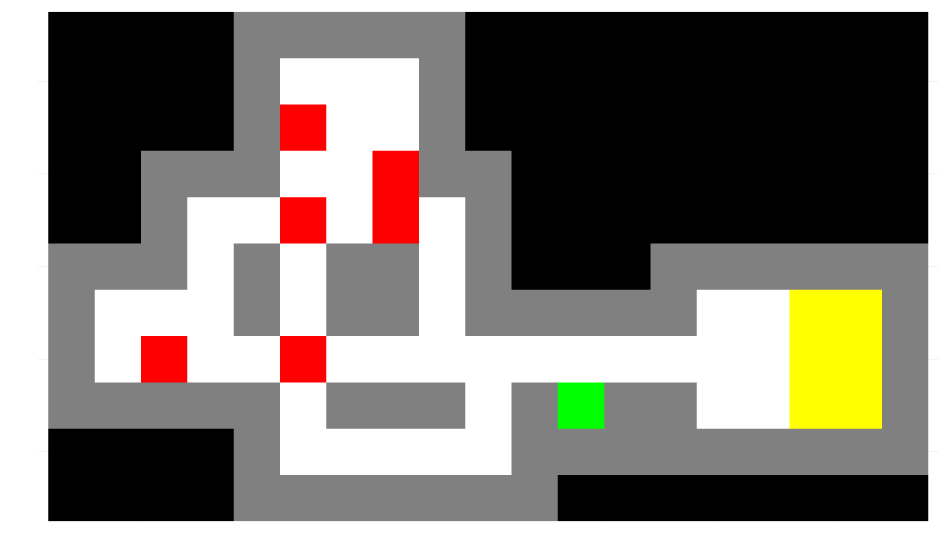

Move (up/down/left/right or single letter , or reset or undo): 

In [ ]:
# Start the game
play_game(levels[1])

In [17]:
test=raw"########
#      #
#@ $   #
#   $  #
# . .  #
########"

"########\n#      #\n#@ \$   #\n#   \$  #\n# . .  #\n########"

stdin>  d


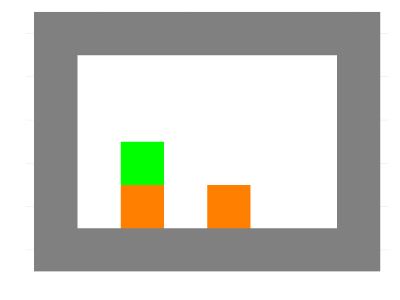

You win!


In [26]:
play_game(test)